In [1]:
# %load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os

import numpy as np
import pandas as pd
import umap

import pyro
import torch

from tqdm import tqdm

<IPython.core.display.Javascript object>

In [3]:
from spexlvm.models import Spex
from spexlvm.callbacks import DebugCallback
from spexlvm.data import DataGenerator
from spexlvm.utils import (
    compute_factor_relevance,
    compute_cf_scores_at,
    compute_confusion_matrix,
)
from spexlvm.plotting import plot_confusion_matrix

<IPython.core.display.Javascript object>

In [4]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using matplotlib backend: <object object at 0x7fb88e91ede0>


<IPython.core.display.Javascript object>

In [5]:
sns.set(rc={"figure.figsize": (11.7, 8.27)})
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1.5,
    rc={"lines.linewidth": 2},
)

<IPython.core.display.Javascript object>

In [6]:
from spexlvm.utils import get_free_gpu_idx

try:
    gpu_idx = get_free_gpu_idx()
    print("Using GPU:%s" % gpu_idx)
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)
except Exception as e:
    print(e)

Using GPU:0


<IPython.core.display.Javascript object>

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = str(device) == "cuda"

if use_cuda:
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

cuda


<IPython.core.display.Javascript object>

In [8]:
# setup synthetic data properties
N_SAMPLES = 1000
N_FEATURES = 2000
N_FACTORS = 100
LIKELIHOOD = "normal"
FACTOR_SIZE_PARAMS = (1.0, 50)
FACTOR_SIZE_DIST = "gamma"

<IPython.core.display.Javascript object>

In [9]:
# generate synthetic data
dg = DataGenerator(
    N_SAMPLES,
    N_FEATURES,
    N_FACTORS,
    LIKELIHOOD,
    FACTOR_SIZE_PARAMS,
    FACTOR_SIZE_DIST,
    )

rng = dg.generate(seed=123)

# center data
dg.normalise(with_std=False)


<IPython.core.display.Javascript object>

In [10]:
def heatmap(data, figsize=(20, 2), annot=False, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    return sns.heatmap(data, annot=annot, ax=ax, **kwargs)

<IPython.core.display.Javascript object>

<AxesSubplot:>

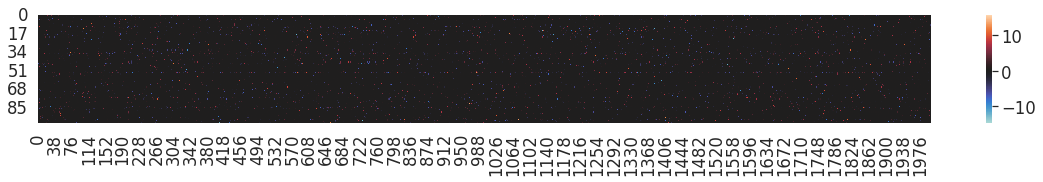

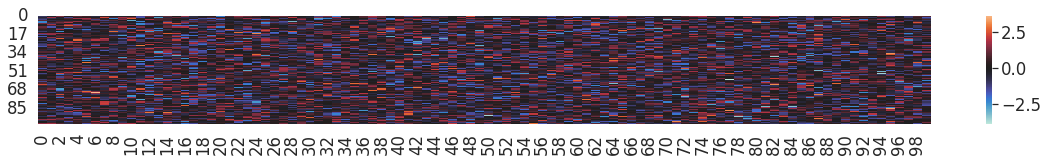

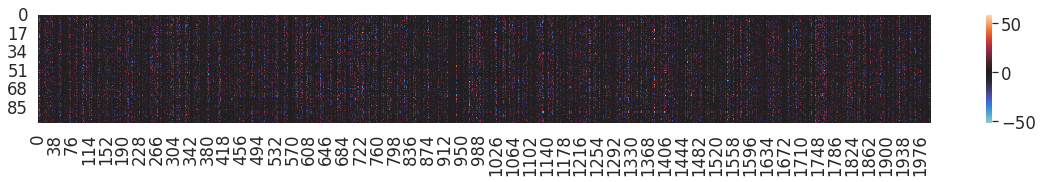

<IPython.core.display.Javascript object>

In [11]:
heatmap(dg.w, center=0)
heatmap(dg.x[:100, :], center=0)
heatmap(dg.y[:100, :], center=0)

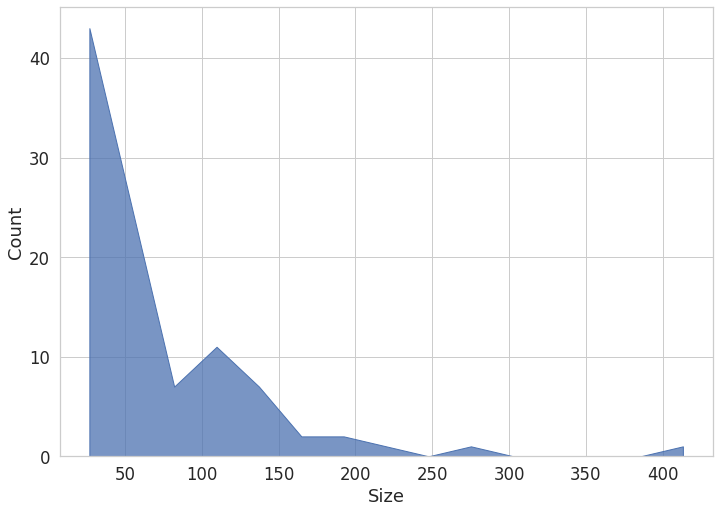

<IPython.core.display.Javascript object>

In [12]:
# the number of active factor loadings follows an exponential distribution as it is common in gene set collections
sns.histplot(pd.DataFrame({"Size": dg.w_mask.sum(1)}), x="Size", element="poly")
plt.show()

<AxesSubplot:>

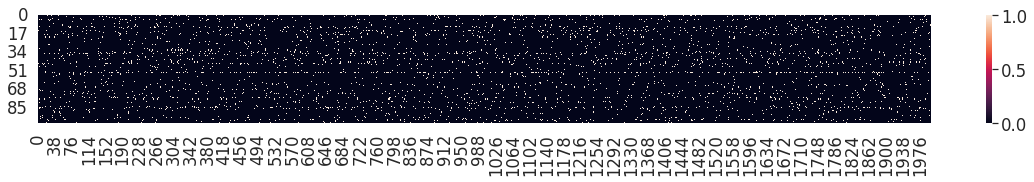

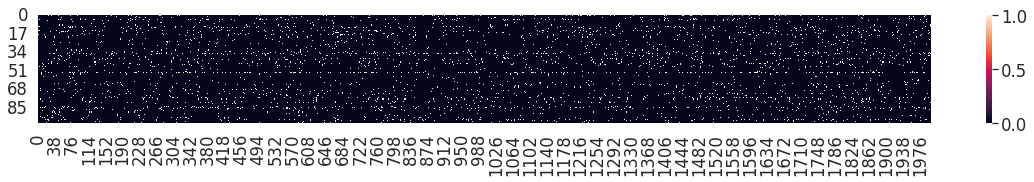

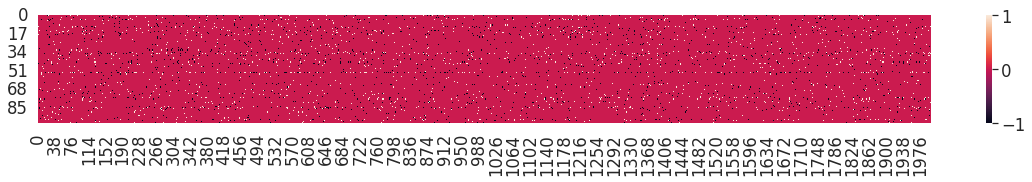

<IPython.core.display.Javascript object>

In [13]:
# perturb the true loadings mask to inform the model with a noisy version
# noise fraction of 0.5 means 50% false positives and 50% false negatives are introduced
_ = dg.get_noisy_w_mask(
    rng,
    noise_fraction=0.5,
)

heatmap(dg.w_mask)
heatmap(dg.noisy_w_mask)

# false positives and false negatives
heatmap(dg.noisy_w_mask - dg.w_mask)

In [14]:
# create an instance of the model
model = Spex(
    n_features=N_FEATURES,
    n_annotated=N_FACTORS,
    likelihood=LIKELIHOOD,
    global_prior_scale=0.1,
    factor_scale_on=True,
    use_cuda=use_cuda,
)

# and build the model by providing the data and the local prior scales
# the local prior scales encode the prior belief that the noisy mask dictates the structure of the factor loadings
# while we know this is incorrect, in reality the ground truth is unavailable
# scale_confidence describes how confident we are regarding the (noisy) prior information
# weak belief ~ 0.9, medium ~ 0.99 and strong ~ 0.999
model.build(
    data=dg.y,
    pathway_mask=dg.noisy_w_mask,
    scale_confidence=0.99,
)

True

<IPython.core.display.Javascript object>

In [15]:
# set number of iterations
n_iterations = 10000
# set random seed
# pyro.set_rng_seed(17062021)

# clean start
print("Cleaning parameter store")
pyro.enable_validation(True)
pyro.clear_param_store()

# this callback logs metrics of the training every X steps to better gauge the training progress
debug_callback = DebugCallback(
    model,
    n_iterations,
    n_checkpoints=10,
    y_true=dg.y,
    mask=dg.w_mask.astype(bool),
    binary_scores_at=500,
    threshold=0.1,
    log=True,
    log_frequency=20,
    n_annotated=N_FACTORS,
)


Cleaning parameter store


<IPython.core.display.Javascript object>

In [16]:
# train the model
loss_history, _ = model.fit(
    batch_size=N_SAMPLES,
    n_iterations=n_iterations,
    learning_rate=0.001,
    optimizer="adam",
    verbose=1,
    callbacks=[debug_callback],
)

2022-01-26 17:55:53 - INFO - Using complete dataset
 10%|████████▏                                                                         | 1001/10000 [00:34<08:37, 17.38it/s, ELBO=2.63e+4]

Average fraction of inactive genes: 0.970
Variance explained (R2): 0.231
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.895, precision: 0.575, recall: 0.562, F1: 0.569


 20%|████████████████▍                                                                 | 2003/10000 [01:13<05:11, 25.71it/s, ELBO=1.43e+4]

Average fraction of inactive genes: 0.972
Variance explained (R2): 0.413
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.898, precision: 0.634, recall: 0.535, F1: 0.580


 30%|████████████████████████▌                                                         | 3002/10000 [01:50<05:46, 20.17it/s, ELBO=9.75e+3]

Average fraction of inactive genes: 0.971
Variance explained (R2): 0.517
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.916, precision: 0.718, recall: 0.617, F1: 0.663


 40%|████████████████████████████████▊                                                 | 4001/10000 [02:27<04:57, 20.17it/s, ELBO=7.23e+3]

Average fraction of inactive genes: 0.968
Variance explained (R2): 0.638
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.941, precision: 0.801, recall: 0.749, F1: 0.774


 50%|█████████████████████████████████████████                                         | 5001/10000 [02:58<03:15, 25.62it/s, ELBO=5.57e+3]

Average fraction of inactive genes: 0.966
Variance explained (R2): 0.785
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.963, precision: 0.875, recall: 0.856, F1: 0.865


 60%|█████████████████████████████████████████████████▏                                | 6001/10000 [03:29<02:39, 25.11it/s, ELBO=4.55e+3]

Average fraction of inactive genes: 0.965
Variance explained (R2): 0.899
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.978, precision: 0.925, recall: 0.916, F1: 0.921


 70%|█████████████████████████████████████████████████████████▍                        | 7001/10000 [04:00<01:59, 25.19it/s, ELBO=3.93e+3]

Average fraction of inactive genes: 0.965
Variance explained (R2): 0.956
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.987, precision: 0.951, recall: 0.955, F1: 0.953


 80%|█████████████████████████████████████████████████████████████████▌                | 8002/10000 [04:32<01:19, 25.12it/s, ELBO=3.51e+3]

Average fraction of inactive genes: 0.965
Variance explained (R2): 0.977
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.992, precision: 0.964, recall: 0.978, F1: 0.971


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9001/10000 [05:11<00:55, 18.04it/s, ELBO=3.17e+3]

Average fraction of inactive genes: 0.965
Variance explained (R2): 0.985
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.995, precision: 0.974, recall: 0.990, F1: 0.982


100%|█████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:42<00:00, 29.18it/s, ELBO=2.89e+3]

Average fraction of inactive genes: 0.965
Variance explained (R2): 0.989
Binary scores between prior mask and learned activations with threshold 0.1 of top 500 (abs) weights:
accuracy: 0.997, precision: 0.984, recall: 0.997, F1: 0.990


<IPython.core.display.Javascript object>

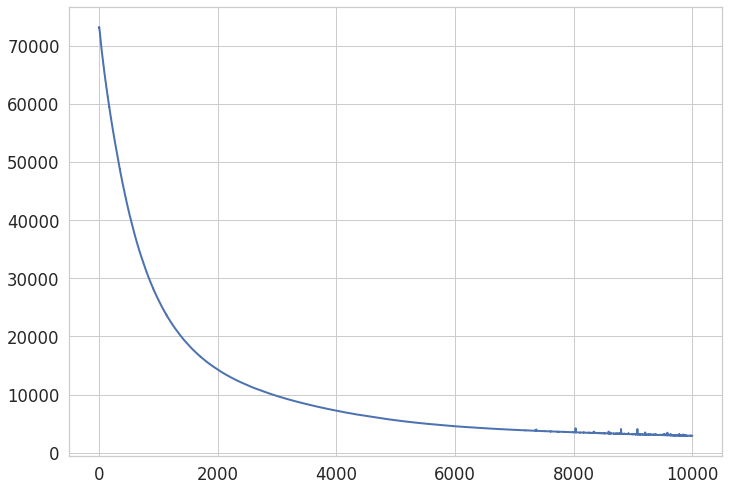

<IPython.core.display.Javascript object>

In [17]:
# plot the ELBO across iterations
plt.plot(loss_history)

In [18]:
# get the learned components
approx_x = model.get_x()
approx_w = model.get_w()
approx_w_mask = (np.abs(approx_w) > 0.1) * 1.0

<IPython.core.display.Javascript object>

In [19]:
def plot_scores(xs, ws, threshold, min_iter):
    indices = np.linspace(0, n_iterations, min_iter, endpoint=False, dtype=np.int32)

    precision_list = []
    recall_list = []
    f1_score_list = []
    r2_list = []
    for i in tqdm(range(len(indices))):
        x = xs[i]
        w = ws[i]
        accuracy, precision, recall, f1_score = compute_cf_scores_at(
            dg.w_mask.astype(bool), w, threshold=0.1
        )
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1_score)
        r2_list.append(compute_factor_relevance(dg.y, x, w, which="acc")[-1])

    scores_df = pd.DataFrame(
        {
            "Checkpoint": list(range(len(indices))),
            "Iteration": indices,
            "Precision": precision_list,
            "Recall": recall_list,
            r"$F_1$": f1_score_list,
            r"$R^2$": r2_list,
        }
    )
    scores_df = pd.melt(
        scores_df,
        id_vars=["Iteration", "Checkpoint"],
        value_vars=["Precision", "Recall", r"$F_1$", r"$R^2$"],
        var_name="Score",
        value_name="Value",
    )

    g = sns.lineplot(
        data=scores_df,
        x="Iteration",
        y="Value",
        hue="Score",
        # style="model",
    )

    return scores_df, g

<IPython.core.display.Javascript object>

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.91it/s]


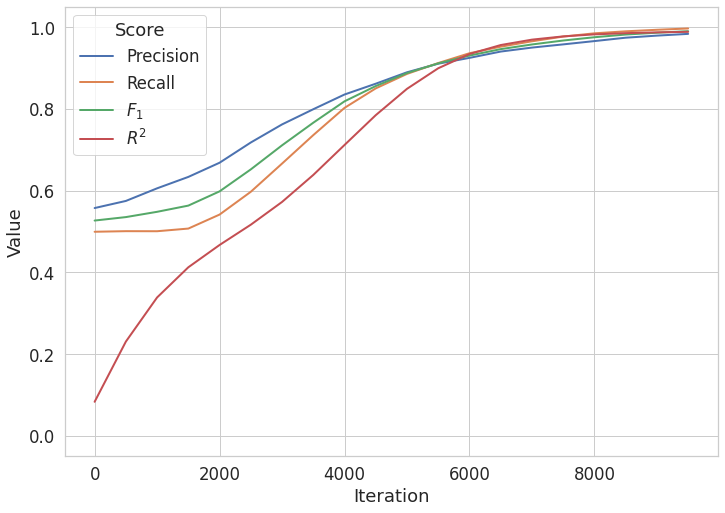

<IPython.core.display.Javascript object>

In [20]:
# plot the progress of the training process wrt different metrics based on the debug_callback
scores_df, g = plot_scores(
    debug_callback.xs,
    debug_callback.ws,
    threshold=0.1,
    min_iter=len(debug_callback.ws),
)
g.set(ylim=(-0.05, 1.05))
plt.show()

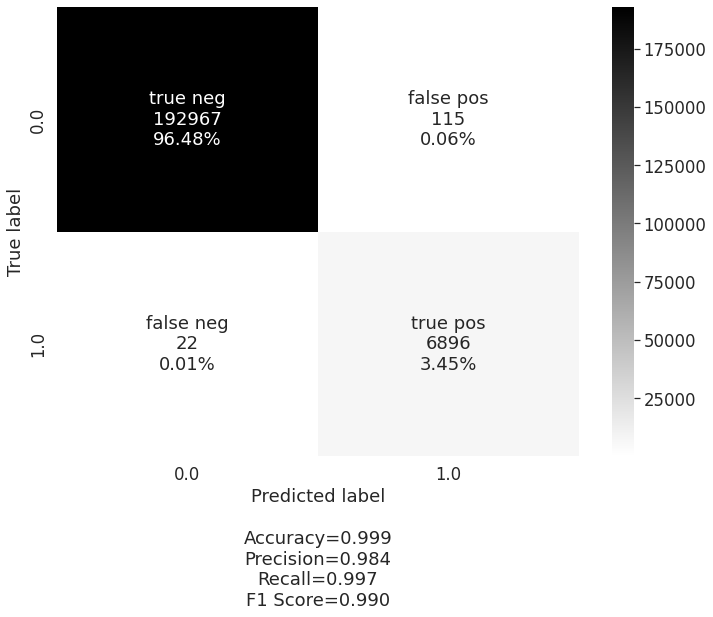

<IPython.core.display.Javascript object>

In [21]:
# plot the confusion matrix between the true loadings activity and the learned loadings activity
cf_matrix = compute_confusion_matrix(dg.w_mask.flatten(), approx_w_mask.flatten())
metrics = plot_confusion_matrix(
    cf_matrix,
    group_names=["true neg", "false pos", "false neg", "true pos"],
    categories=["0.0", "1.0"],
    cmap="binary",
)
plt.show()

In [22]:
def get_factor_activity_df(approx_w, true_w, true_mask, noisy_mask, factor_idx=0):

    w_col = approx_w[factor_idx, :]
    true_mask_col = true_mask[factor_idx, :]
    noisy_mask_col = noisy_mask[factor_idx, :]

    activity_df = pd.DataFrame(
        {
            "true_weight": true_w[factor_idx, :],
            "weight": w_col,
            "true_mask": true_mask_col,
            "noisy_mask": noisy_mask_col,
            "TP": true_mask_col * noisy_mask_col,
            "FP": (1 - true_mask_col) * noisy_mask_col,
            "TN": (1 - true_mask_col) * (1 - noisy_mask_col),
            "FN": true_mask_col * (1 - noisy_mask_col),
        }
    )
    activity_df.sort_values(["true_weight"], inplace=True)

    score_cols = ["TP", "FP", "TN", "FN"]

    assert (activity_df.loc[:, score_cols].values.sum(1) == 1).all()
    activity_df["state"] = (
        activity_df.loc[:, score_cols]
        .astype(np.int32)
        .dot(activity_df.loc[:, score_cols].columns + "+")
        .str[:-1]
    )
    activity_df["true state"] = [
        "on" if f > 0.5 else "off" for f in activity_df["true_mask"]
    ]
    activity_df["idx"] = list(range(len(w_col)))
    # activity_df
    return activity_df



<IPython.core.display.Javascript object>

In [23]:
def plot_factor_activity(
    activity_df,
    ylim=None,
    **kwargs,
):
    g = sns.scatterplot(
        data=activity_df,
        x="idx",
        y="weight",
        hue="state",
        hue_order=["TP", "FN", "TN", "FP"],
        style="true state",
        style_order=["on", "off"],
        size="state",
        sizes={"TP": 128, "FN": 128, "TN": 42, "FP": 42},
        linewidth=0.01,
        **kwargs,
    )
    g.set_xlabel("")
    joint_handles, joint_labels = g.get_legend_handles_labels()
    g.legend(
        # loc="lower right",
        handles=[h for i, h in enumerate(joint_handles) if i not in [0, 5]],
        labels=[h for i, h in enumerate(joint_labels) if i not in [0, 5]],
    )
    if ylim is not None:
        g.set(ylim=ylim)

    return g

<IPython.core.display.Javascript object>

In [24]:
activity_df = get_factor_activity_df(
    model.get_w(), dg.w, dg.w_mask, dg.noisy_w_mask, factor_idx=0
)
activity_df.head()

,true_weight,weight,true_mask,noisy_mask,TP,FP,TN,FN,state,true state,idx
1818,-9.734256,-4.398852,1.0,0.0,0.0,0.0,0.0,1.0,FN,on,0
1708,-8.935477,-4.029213,1.0,1.0,1.0,0.0,0.0,0.0,TP,on,1
1013,-7.895787,-3.559564,1.0,1.0,1.0,0.0,0.0,0.0,TP,on,2
1780,-7.522078,-3.425915,1.0,0.0,0.0,0.0,0.0,1.0,FN,on,3
446,-7.229845,-3.267148,1.0,0.0,0.0,0.0,0.0,1.0,FN,on,4


<IPython.core.display.Javascript object>

<AxesSubplot:ylabel='weight'>

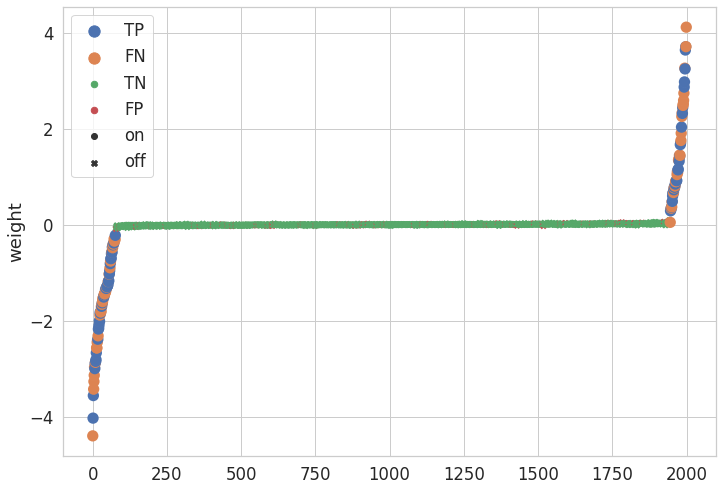

<IPython.core.display.Javascript object>

In [25]:
# we can also go deeper and inspect single factors by plotting the sorted weights
# and their corresponding state (TP, TN, FP, FN)
# ideally we would like to see true active loadings away from zero, and TN/FP close to zero
plot_factor_activity(activity_df)

Have a look at our next [notebook](mesc_evaluation.ipynb) for a basic application of spex-LVM on a mouse embryonic stem cell dataset, or go to this [notebook](kang_evaluation.ipynb) for a more extensive analysis of peripheral blood mononuclear cells from lupus patients.